# QCNN Camera-Only Odometry (Hybrid CNN + QCNN)

In [1]:
import os, sys, math
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pennylane as qml
from tqdm import tqdm

sys.path.append("/home/gurman_preet_526_gmail_com/lusnar_slam/src")
from lusnar_dataset import LuSNARDataset

plt.rcParams["figure.dpi"] = 120
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
DATA_ROOT = Path("/home/gurman_preet_526_gmail_com/lusnar_slam/datasets/Moon_1")
ds = LuSNARDataset(DATA_ROOT)

gt = ds.gt.astype(np.float64)
gt_xyz = gt[:, 1:4]
color_ts = ds.color_ts.astype(np.int64)

MAX_FRAMES = 600
N = min(MAX_FRAMES, len(color_ts), gt_xyz.shape[0])
color_ts = color_ts[:N]
t_gt = gt_xyz[:N]

print("Frames:", N)
print("GT shape:", t_gt.shape)
print("Color timestamps shape:", color_ts.shape)

[LuSNAR] Loaded 1094 frames.
Frames: 600
GT shape: (600, 3)
Color timestamps shape: (600,)


In [3]:
# === QCNN / hybrid config & GT normalization ===
IMG_SIZE = 64      # image will be resized to 64x64
N_QUBITS = 8
N_Q_LAYERS = 3

# Normalize ground-truth translations to stabilize training
t_mean = t_gt.mean(axis=0).astype(np.float32)
t_std = t_gt.std(axis=0).astype(np.float32) + 1e-6  # avoid divide-by-zero

print("t_mean:", t_mean)
print("t_std:", t_std)

t_mean: [67.3173     -1.1945682   0.19983587]
t_std: [4.1211300e+01 2.5928457e+00 3.7261482e-02]


In [4]:
def translation_rmse(pred, gt):
    """Compute translation RMSE (in meters)."""
    diff = pred - gt
    err = np.linalg.norm(diff, axis=1)
    return float(np.sqrt(np.mean(err ** 2))), err

Img tensor shape: torch.Size([3, 64, 64])


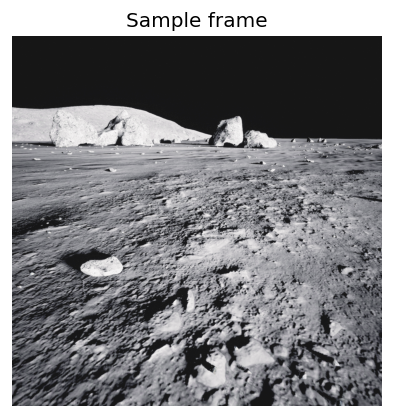

In [5]:
# Image preprocessing helper (BGR from OpenCV -> torch tensor)
def preprocess_image_bgr_to_tensor(rgb_bgr):
    """Input: BGR image (H,W,3); Output: float tensor (3, IMG_SIZE, IMG_SIZE) in [0,1]."""
    rgb = cv2.cvtColor(rgb_bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    rgb = rgb.astype(np.float32) / 255.0
    # (H,W,3) -> (3,H,W)
    rgb = np.transpose(rgb, (2, 0, 1))
    return torch.from_numpy(rgb)

# Quick sanity check and visualization
rgb0 = ds.load_rgb(int(color_ts[0]))
img_t = preprocess_image_bgr_to_tensor(rgb0)

print("Img tensor shape:", img_t.shape)

plt.figure(figsize=(5, 4))
plt.imshow(cv2.cvtColor(rgb0, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Sample frame")
plt.show()

In [6]:
# === Quantum device and QCNN block ===
qdev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(qdev, interface="torch")
def qcnn_block(inputs, weights):
    """QCNN-style variational block.
    inputs: (N_QUBITS,) tensor of rotation angles.
    weights: StronglyEntanglingLayers parameters.
    """
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS))
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes = {"weights": (N_Q_LAYERS, N_QUBITS, 3)}
QuantumLayer = qml.qnn.TorchLayer(qcnn_block, weight_shapes)


class HybridQCNNPoseNet(nn.Module):
    """Hybrid CNN + QCNN PoseNet for camera-only odometry.

    - CNN extracts a 64-D feature vector from the RGB image.
    - Linear layer maps it to N_QUBITS angles.
    - QCNN (quantum block) processes angles.
    - MLP head regresses normalized (x,y,z) translation.
    """
    def __init__(self):
        super().__init__()

        # CNN front-end
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 64 -> 32

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 32 -> 16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)   # -> (64,1,1)
        )

        # Map CNN feature vector to quantum rotation angles
        self.to_angles = nn.Linear(64, N_QUBITS)

        # Quantum "convolution" layer
        self.qconv = QuantumLayer

        # MLP head on top of quantum features
        self.head = nn.Sequential(
            nn.Linear(N_QUBITS, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 3)  # predicts normalized (x,y,z)
        )

    def forward(self, x):
        # x: (B, 3, IMG_SIZE, IMG_SIZE)
        feat = self.cnn(x)               # (B, 64, 1, 1)
        feat = feat.view(feat.size(0), -1)  # (B, 64)

        angles = self.to_angles(feat)    # (B, N_QUBITS)
        # keep angles in [-pi, pi]
        angles = torch.tanh(angles) * math.pi

        qfeat = self.qconv(angles)       # (B, N_QUBITS)
        out = self.head(qfeat)           # (B, 3) normalized translation
        return out


class QuantumCameraDataset(Dataset):
    """Dataset returning (image_tensor, normalized_translation)."""
    def __init__(self, ds, color_ts, t_gt, t_mean, t_std):
        self.ds = ds
        self.color_ts = color_ts
        self.t_gt = t_gt.astype(np.float32)
        self.t_mean = t_mean.astype(np.float32)
        self.t_std = t_std.astype(np.float32)

    def __len__(self):
        return len(self.color_ts)

    def __getitem__(self, idx):
        ts = int(self.color_ts[idx])
        rgb = self.ds.load_rgb(ts)
        img_tensor = preprocess_image_bgr_to_tensor(rgb)  # (3, IMG_SIZE, IMG_SIZE)

        t = self.t_gt[idx]
        t_norm = (t - self.t_mean) / self.t_std  # normalize target

        return img_tensor, torch.from_numpy(t_norm)


# Build dataset and loaders
qcam_ds = QuantumCameraDataset(ds, color_ts, t_gt, t_mean, t_std)

val_ratio = 0.2
n_val = int(len(qcam_ds) * val_ratio)
n_train = len(qcam_ds) - n_val

qcam_train, qcam_val = random_split(qcam_ds, [n_train, n_val])

train_loader_cam = DataLoader(
    qcam_train, batch_size=8, shuffle=True, num_workers=4, pin_memory=True
)
val_loader_cam = DataLoader(
    qcam_val, batch_size=8, shuffle=False, num_workers=4, pin_memory=True
)

qposenet = HybridQCNNPoseNet().to(device)
criterion_cam = nn.MSELoss()
optimizer_cam = torch.optim.Adam(qposenet.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_cam = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_cam, factor=0.5, patience=3, verbose=True
)

print("Train/Val sizes:", len(qcam_train), len(qcam_val))
print("Total params (M):", sum(p.numel() for p in qposenet.parameters()) / 1e6)

Train/Val sizes: 480 120
Total params (M): 0.025267


/home/gurman_preet_526_gmail_com/slam-env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



[QCNN] Epoch 01/25


  train=0.999568 | val=0.972640 | best_val=0.972640

[QCNN] Epoch 02/25


  train=0.907800 | val=1.161537 | best_val=0.972640

[QCNN] Epoch 03/25


  train=0.717267 | val=0.812454 | best_val=0.812454

[QCNN] Epoch 04/25


  train=0.545775 | val=0.461213 | best_val=0.461213

[QCNN] Epoch 05/25


  train=0.474095 | val=0.438270 | best_val=0.438270

[QCNN] Epoch 06/25


  train=0.427316 | val=0.805549 | best_val=0.438270

[QCNN] Epoch 07/25


  train=0.383681 | val=0.875723 | best_val=0.438270

[QCNN] Epoch 08/25


  train=0.358136 | val=0.417994 | best_val=0.417994

[QCNN] Epoch 09/25


  train=0.292975 | val=0.970308 | best_val=0.417994

[QCNN] Epoch 10/25


  train=0.257895 | val=0.246419 | best_val=0.246419

[QCNN] Epoch 11/25


  train=0.236807 | val=0.249669 | best_val=0.246419

[QCNN] Epoch 12/25


  train=0.222751 | val=0.555939 | best_val=0.246419

[QCNN] Epoch 13/25


  train=0.194737 | val=0.919020 | best_val=0.246419

[QCNN] Epoch 14/25


  train=0.187648 | val=0.392394 | best_val=0.246419

[QCNN] Epoch 15/25


  train=0.177438 | val=0.187049 | best_val=0.187049

[QCNN] Epoch 16/25


  train=0.157925 | val=0.123353 | best_val=0.123353

[QCNN] Epoch 17/25


  train=0.155093 | val=0.258787 | best_val=0.123353

[QCNN] Epoch 18/25


  train=0.160549 | val=0.178111 | best_val=0.123353

[QCNN] Epoch 19/25


  train=0.133998 | val=0.148436 | best_val=0.123353

[QCNN] Epoch 20/25


  train=0.143939 | val=0.142973 | best_val=0.123353

[QCNN] Epoch 21/25


  train=0.136685 | val=0.148383 | best_val=0.123353

[QCNN] Epoch 22/25


  train=0.126991 | val=0.085181 | best_val=0.085181

[QCNN] Epoch 23/25


  train=0.132010 | val=0.080906 | best_val=0.080906

[QCNN] Epoch 24/25


  train=0.107706 | val=0.092587 | best_val=0.080906

[QCNN] Epoch 25/25


  train=0.126053 | val=0.227066 | best_val=0.080906
Loaded best model (val MSE = 0.080906)


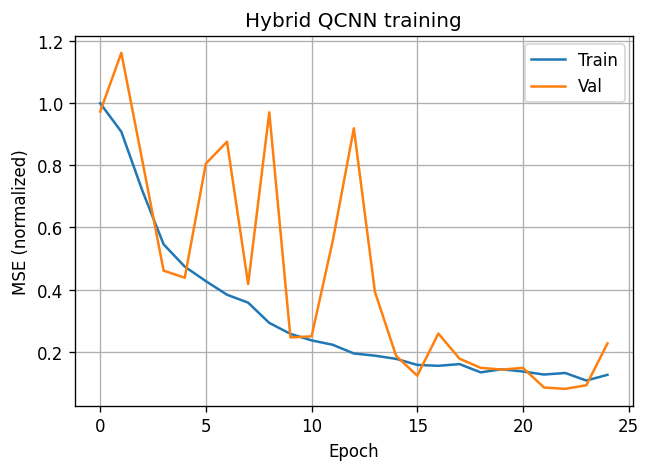

In [7]:
def run_epoch_qcnn(loader, model, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0.0
    n = 0

    for xb, yb in tqdm(loader, leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        if optimizer is not None:
            optimizer.zero_grad()

        pred = model(xb)  # normalized translations
        loss = criterion_cam(pred, yb)

        if optimizer is not None:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        n += xb.size(0)

    return total_loss / max(n, 1)


NUM_EPOCHS_CAM = 25
train_losses_cam, val_losses_cam = [], []
best_val = float("inf")
best_state = None

for epoch in range(1, NUM_EPOCHS_CAM + 1):
    print(f"\n[QCNN] Epoch {epoch:02d}/{NUM_EPOCHS_CAM}")
    train_loss = run_epoch_qcnn(train_loader_cam, qposenet, optimizer_cam)
    val_loss = run_epoch_qcnn(val_loader_cam, qposenet, optimizer=None)

    train_losses_cam.append(train_loss)
    val_losses_cam.append(val_loss)

    scheduler_cam.step(val_loss)

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in qposenet.state_dict().items()}

    print(f"  train={train_loss:.6f} | val={val_loss:.6f} | best_val={best_val:.6f}")

# Restore best model
if best_state is not None:
    qposenet.load_state_dict(best_state)
    qposenet.to(device)
    print("Loaded best model (val MSE = {:.6f})".format(best_val))

plt.figure(figsize=(6, 4))
plt.plot(train_losses_cam, label="Train")
plt.plot(val_losses_cam, label="Val")
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized)")
plt.title("Hybrid QCNN training")
plt.grid(True)
plt.legend()
plt.show()

Hybrid QCNN Camera RMSE [m]: 13.808242073055498


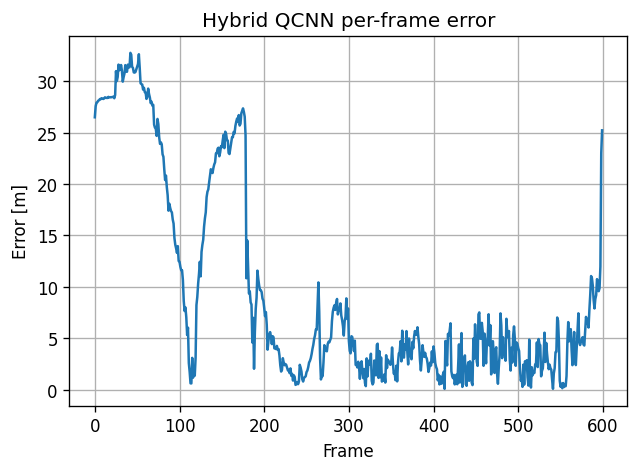

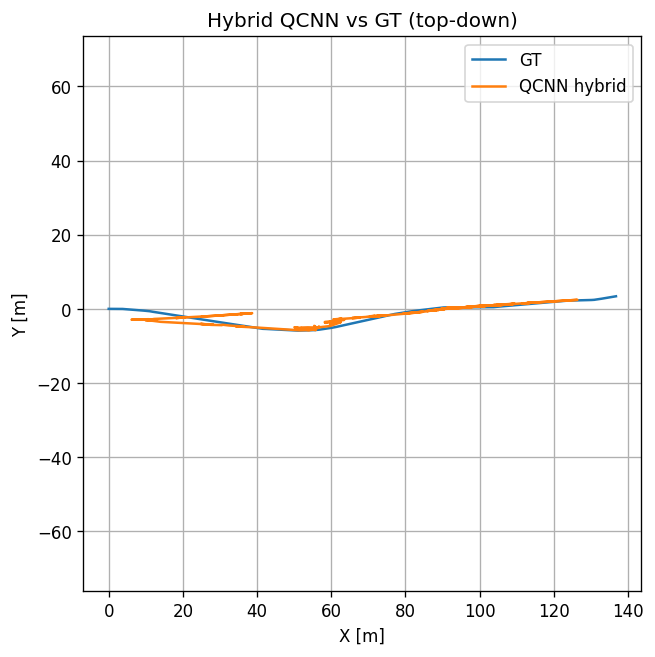

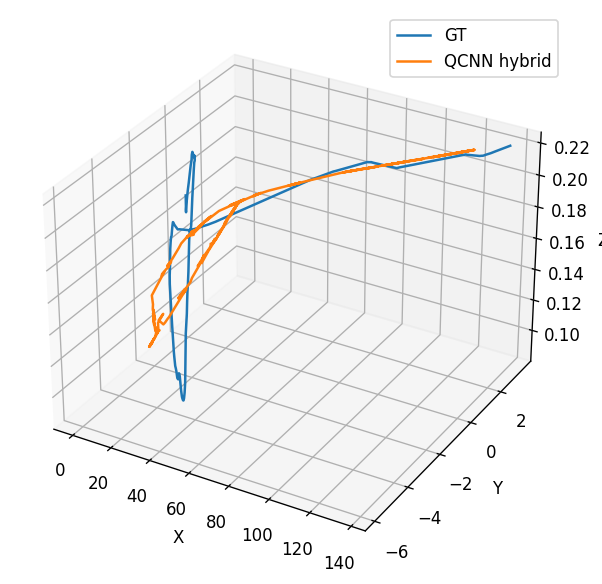

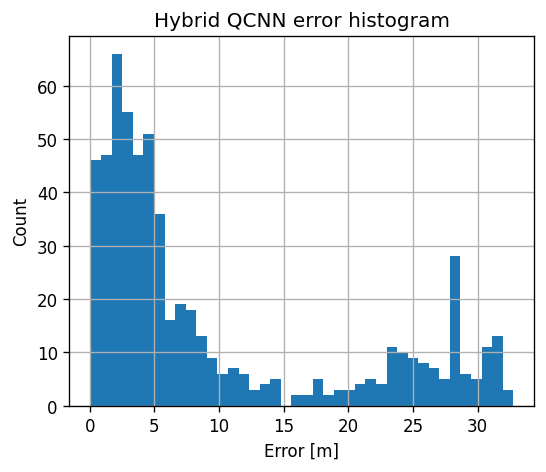

In [8]:
qposenet.eval()

# Convert mean/std to torch (CPU)
t_mean_t = torch.from_numpy(t_mean)
t_std_t = torch.from_numpy(t_std)

t_cam_list = []
with torch.no_grad():
    for i in range(N):
        ts = int(color_ts[i])
        rgb = ds.load_rgb(ts)
        img = preprocess_image_bgr_to_tensor(rgb).unsqueeze(0).to(device)  # (1,3,H,W)

        t_pred_norm = qposenet(img)[0].cpu()  # normalized prediction
        t_pred = t_pred_norm * t_std_t + t_mean_t
        t_cam_list.append(t_pred.numpy())

t_cam = np.stack(t_cam_list, axis=0)
rmse_cam, err_cam = translation_rmse(t_cam, t_gt)
print("Hybrid QCNN Camera RMSE [m]:", rmse_cam)

plt.figure(figsize=(6, 4))
plt.plot(err_cam)
plt.xlabel("Frame")
plt.ylabel("Error [m]")
plt.title("Hybrid QCNN per-frame error")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(t_gt[:, 0], t_gt[:, 1], label="GT")
plt.plot(t_cam[:, 0], t_cam[:, 1], label="QCNN hybrid")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Hybrid QCNN vs GT (top-down)")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(t_gt[:, 0], t_gt[:, 1], t_gt[:, 2], label="GT")
ax.plot(t_cam[:, 0], t_cam[:, 1], t_cam[:, 2], label="QCNN hybrid")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

plt.figure(figsize=(5, 4))
plt.hist(err_cam, bins=40)
plt.xlabel("Error [m]")
plt.ylabel("Count")
plt.title("Hybrid QCNN error histogram")
plt.grid(True)
plt.show()

In [9]:
out_dir = Path("/home/gurman_preet_526_gmail_com/lusnar_slam/results_qcnn_hybrid")
out_dir.mkdir(parents=True, exist_ok=True)

np.save(out_dir / "t_gt.npy", t_gt)
np.save(out_dir / "t_cam_qcnn_hybrid.npy", t_cam)
np.save(out_dir / "err_cam_qcnn_hybrid.npy", err_cam)
np.savez(out_dir / "metrics_qcnn_hybrid.npz", rmse_cam=rmse_cam, N=N)

print("Saved to", out_dir)

Saved to /home/gurman_preet_526_gmail_com/lusnar_slam/results_qcnn_hybrid
